In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
'''
load_img: resim yüklemeye yarıyan bir kütüphane.
img_to_array = görünlüyü listeye çeviriyor.
Image resim yüklemeye yarayan bir kütüphane.
'''
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from PIL import Image
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [3]:
Main_Path = '../input/celeba-dataset/'
Data_Path = Main_Path + 'img_align_celeba/img_align_celeba/'
Attribute_Path  = Main_Path + 'list_attr_celeba.csv'
Partition_Path = Main_Path + 'list_eval_partition.csv'

Example_Pic = Data_Path + '000002.jpg'
Img_Width = 178
Img_Height = 218

Training_Samples = 10000
Valisadion_Samples = 1000
Test_Samples = 1000

Batch_Size = 60
Num_Epochs = 30
Input_Shape = (Img_Width, Img_Height, 3)

In [4]:
attr_df = pd.read_csv(Attribute_Path, index_col='image_id')
attr_df.replace(to_replace=-1, value=0, inplace=True)

<AxesSubplot:title={'center':'Gender Distribution'}, xlabel='count', ylabel='Male'>

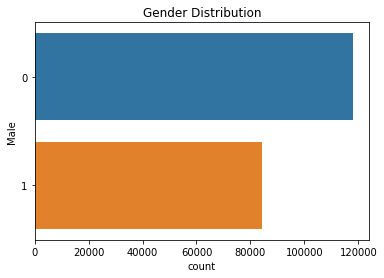

In [5]:
plt.title("Gender Distribution")
sns.countplot(y="Male",data= attr_df)

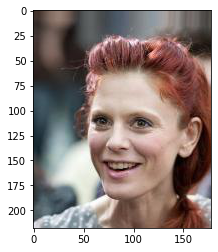

In [6]:
img = load_img(Example_Pic)
plt.imshow(img)
plt.show()

In [7]:
partition_df = pd.read_csv(Partition_Path, index_col='image_id')
partition_df.head()

,partition
image_id,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0


In [8]:
sampling_df = attr_df[['Male']].join(partition_df)
sampling_df.head()

,Male,partition
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [9]:
# veri çekiyor ve boyutlandırıyor
def load_reshape_img(filename):
    img = load_img(filename)
    img_array = img_to_array(img)/255
    img_array = img_array.reshape((1,) + img_array.shape)
    return img_array
'''!!! reshape kısmını elle bir dene tam oturmadı nasıl bir boyuta çeviriyor'''

'!!! reshape kısmını elle bir dene tam oturmadı nasıl bir boyuta çeviriyor'

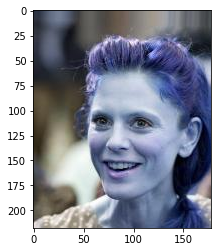

In [10]:
# işreti bölüyor ve bölümü alıyor.
# partition a göre ayarlıyor yarısını kız yarısını erkek seçiyor ve bunları birleştiriyor. Sonrasında for döngüsü ie resimleri dosyadan içeri aktarıyor 
# imread fonksiyonu resmi mavi yeşil kırmızı yapar bunu değiştirmek için 'cv2.COLOR_BGR2RGB' kodu kullanılabilir.

im = cv2.imread(Data_Path + '000002.jpg')

plt.imshow(im)

In [11]:
# saple_size // 2 kısmı ayrılan kısımdaki resimleri karışık bir şekilde çekiyor
# appened ile eklediğimizden başta sıfırlıyoruz
# expand_dims : methodu boyutu arttırıyor. Boyutu (2,4) --> (1,2,4) yapıyor. Bu kodda ise birden çok resim birbirine karışmasın diye boyur arttırıldı diye düşünüyorum

def sampling(partition, sample_size, sampling_df):
    parti_mask = sampling_df['partition'] == partition
    male_mask = sampling_df['Male'] == 1
    female_mask = sampling_df['Male'] == 0
    sampled_df = pd.concat([sampling_df[parti_mask & male_mask].sample(sample_size//2),
                          sampling_df[parti_mask & female_mask].sample(sample_size//2)])
    
    if partition != 2:
        x = np.array([load_reshape_img(Data_Path + filename) for filename in sampled_df.index])
        x = x.reshape(x.shape[0], 218, 178, 3)
        y = np_utils.to_categorical(sampled_df['Male'],2)
    else:
        x = []
        y = []
        for index, target in sampled_df.iterrows():
            im = cv2.imread(Data_Path + index) # return BGR
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (Img_Width, Img_Height)).astype(np.float32) / 255.0 # convert it to RGB for consistency
            im = np.expand_dims(im, axis =0)
            x.append(im)
            y.append(target['Male'])
        
    return x,y

In [12]:
x_train, y_train = sampling(0, Training_Samples, sampling_df)
x_valid, y_valid = sampling(1, Valisadion_Samples, sampling_df)
x_test, y_test = sampling(2, Test_Samples, sampling_df)

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train, y_train,batch_size=Batch_Size)

# My CNN Code

In [14]:
# Modelişe yaramdı doğruluk çok düşük ve bir düşüp bir çıkıyor
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding = "same", input_shape=(Img_Height, Img_Width, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = "same"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = "same"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation="softmax")
])

2022-10-26 06:17:21.430274: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 218, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 218, 178, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 218, 178, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 89, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 109, 89, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 89, 64)       18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 89, 64)       3

In [16]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [17]:

history = model.fit(
      train_generator,
      steps_per_epoch= 60,
      epochs=30,
      verbose=1,
      validation_data = (x_valid,y_valid)
) # val: %74 ac: %84

2022-10-24 11:12:44.987695: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
60/60 [==============================] - 339s 6s/step - loss: 5.6073 - accuracy: 0.5739 - val_loss: 2.9012 - val_accuracy: 0.5020
Epoch 2/30
60/60 [==============================] - 329s 5s/step - loss: 0.8128 - accuracy: 0.6561 - val_loss: 1.2183 - val_accuracy: 0.4840
Epoch 3/30
60/60 [==============================] - 330s 5s/step - loss: 0.7199 - accuracy: 0.6775 - val_loss: 1.6029 - val_accuracy: 0.5670
Epoch 4/30
60/60 [==============================] - 321s 5s/step - loss: 0.6309 - accuracy: 0.7042 - val_loss: 0.9675 - val_accuracy: 0.5710
Epoch 5/30
60/60 [==============================] - 323s 5s/step - loss: 0.5896 - accuracy: 0.7217 - val_loss: 0.9966 - val_accuracy: 0.5290
Epoch 6/30
60/60 [==============================] - 311s 5s/step - loss: 0.6204 - accuracy: 0.7014 - val_loss: 1.0408 - val_accuracy: 0.6570
Epoch 7/30
60/60 [==============================] - 311s 5s/step - loss: 0.5825 - accuracy: 0.7364 - val_loss: 2.2561 - val_accuracy: 0.5570
Epoch 8/30
60

# inception_v3 Model

In [17]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

InceptionV3_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(Img_Height, Img_Width, 3))
print("number of layers:", len(InceptionV3_model.layers))

87924736/87910968 [==============================] - 0s 0us/step
number of layers: 311


In [18]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D

x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)

predictions = Dense(2, activation="softmax")(x)

In [19]:
from tensorflow.keras.models import Model

# creating the final model 
model = Model(inputs=InceptionV3_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model.layers[:52]:
    layer.trainable = False

In [20]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.0001, momentum=0.9), 
              metrics=['accuracy'])

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.h5', 
                               verbose=1, 
                               save_best_only=True)

In [ ]:
hist = model.fit(train_generator, 
                 validation_data = (x_valid, y_valid), 
                 steps_per_epoch= Training_Samples/Batch_Size, 
                 epochs= Num_Epochs, 
                 callbacks=[checkpointer,callback], 
                 verbose=1)

2022-10-26 06:17:25.456895: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
166/166 [==============================] - 1012s 6s/step - loss: 0.6616 - accuracy: 0.6014 - val_loss: 0.4627 - val_accuracy: 0.8540

Epoch 00001: val_loss improved from inf to 0.46275, saving model to model.h5
Epoch 2/30
166/166 [==============================] - 1004s 6s/step - loss: 0.5124 - accuracy: 0.7665 - val_loss: 0.3299 - val_accuracy: 0.8880

Epoch 00002: val_loss improved from 0.46275 to 0.32993, saving model to model.h5
Epoch 3/30
166/166 [==============================] - 1002s 6s/step - loss: 0.4039 - accuracy: 0.8336 - val_loss: 0.2614 - val_accuracy: 0.8940

Epoch 00003: val_loss improved from 0.32993 to 0.26143, saving model to model.h5
Epoch 4/30
166/166 [==============================] - 998s 6s/step - loss: 0.3369 - accuracy: 0.8617 - val_loss: 0.2245 - val_accuracy: 0.9100

Epoch 00004: val_loss improved from 0.26143 to 0.22447, saving model to model.h5
Epoch 5/30
 97/166 [================>.............] - ETA: 6:40 - loss: 0.3048 - accuracy: 0.8786

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Model Evaluation
model.load_weights('model.h5')
predictions = [np.argmax(model.predict(image)) for image in x_test]
accuracy = 100 * np.sum(np.array(predictions)==y_test) / len(predictions)
f1 = f1_score(y_test, predictions)

print('Accuracy: {:.4f}'.format(accuracy))
print('F1 score: {:.4f}'.format(f1))